In [2]:
import matplotlib.pyplot as plt
import numpy as np


# aux1


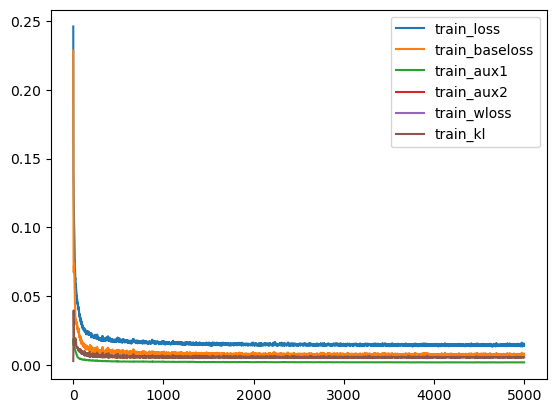

In [2]:
metrics = np.load('./sign/metrics/M_mse_512_256_128_5000_peryton_sign2_aux1.npy', allow_pickle=True).item()
metrics.keys()
train_loss = metrics['train_loss']
train_baseloss = metrics['train_baseloss']
train_aux1 = metrics['train_aux1']
train_aux2 = metrics['train_aux2']
train_wloss = metrics['train_wloss']
train_kl = metrics['train_kl']
train_r2 = metrics['train_r2']
train_RMSE = metrics['train_RMSE']
plt.figure()
plt.plot(train_loss)
plt.plot(train_baseloss)
plt.plot(train_aux1)
plt.plot(train_aux2)
plt.plot(train_wloss)
plt.plot(train_kl)
plt.legend(['train_loss', 'train_baseloss', 'train_aux1', 'train_aux2', 'train_wloss', 'train_kl'])

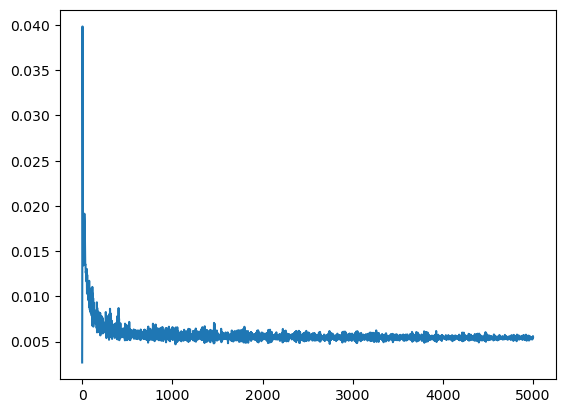

In [10]:
plt.figure()
plt.plot(train_kl)

# aux1


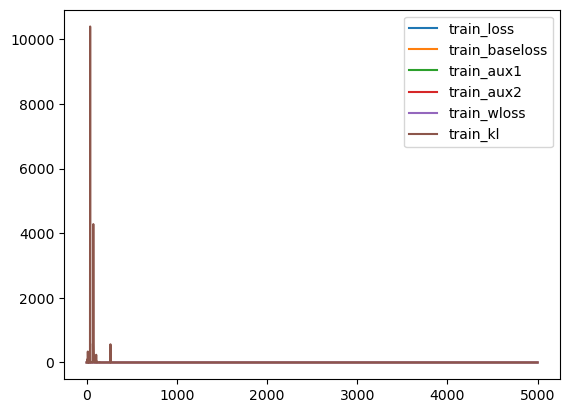

In [20]:
metrics = np.load('./sign/metrics/M_mse_512_256_128_5000_peryton_sign2_2w.npy', allow_pickle=True).item()
metrics.keys()
train_loss = metrics['train_loss']
train_baseloss = metrics['train_baseloss']
train_aux1 = metrics['train_aux1']
train_aux2 = metrics['train_aux2']
train_wloss = metrics['train_wloss']
train_kl = metrics['train_kl']
train_r2 = metrics['train_r2']
train_RMSE = metrics['train_RMSE']
plt.figure()
plt.plot(train_loss)
plt.plot(train_baseloss)
plt.plot(train_aux1)
plt.plot(train_aux2)
plt.plot(train_wloss)
plt.plot(train_kl)
plt.legend(['train_loss', 'train_baseloss', 'train_aux1', 'train_aux2', 'train_wloss', 'train_kl'])

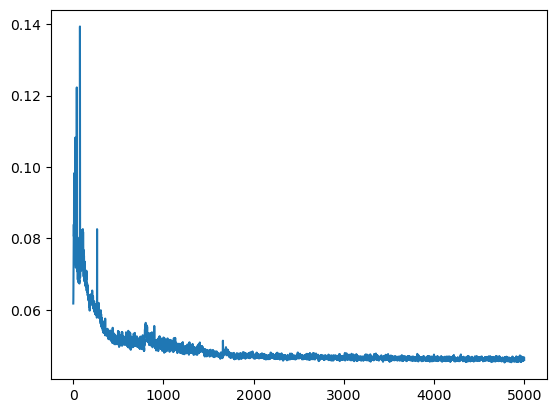

In [24]:
plt.figure()
plt.plot(train_wloss)

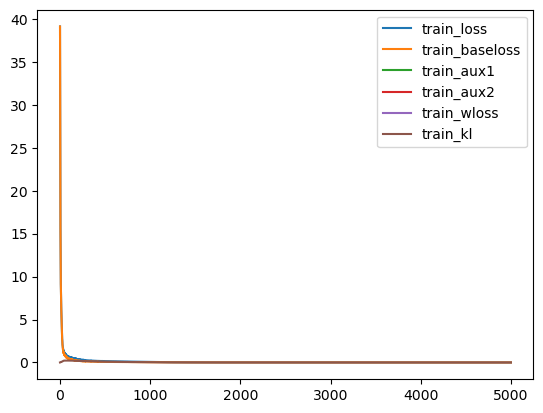

In [35]:
metrics = np.load('./sign/metrics/M_mse_512_256_128_5000_peryton_sign2_leakyReLU_base.npy', allow_pickle=True).item()
metrics.keys()
train_loss = metrics['train_loss']
train_baseloss = metrics['train_baseloss']
train_aux1 = metrics['train_aux1']
train_aux2 = metrics['train_aux2']
train_wloss = metrics['train_wloss']
train_kl = metrics['train_kl']
train_r2 = metrics['train_r2']
train_RMSE = metrics['train_RMSE']
plt.figure()
plt.plot(train_loss)
plt.plot(train_baseloss)
plt.plot(train_aux1)
plt.plot(train_aux2)
plt.plot(train_wloss)
plt.plot(train_kl)
plt.legend(['train_loss', 'train_baseloss', 'train_aux1', 'train_aux2', 'train_wloss', 'train_kl'])

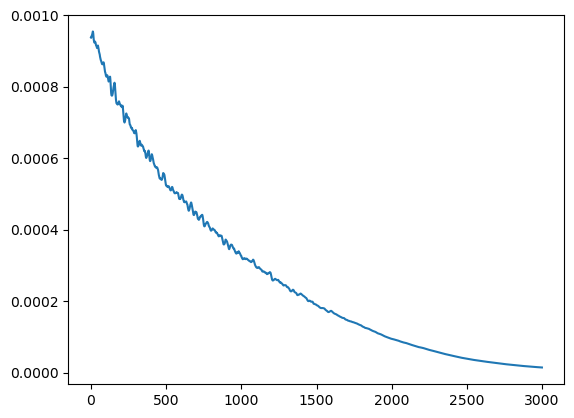

In [36]:
plt.plot(train_kl[2000:])

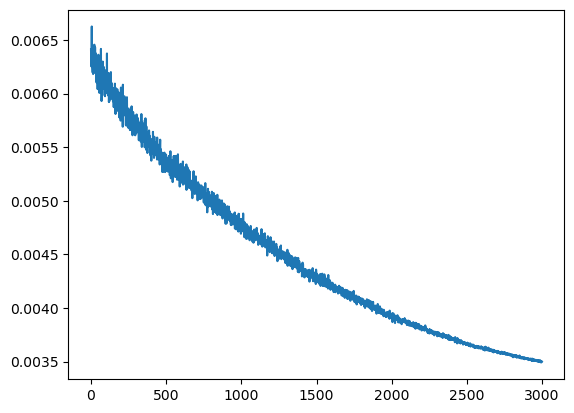

In [37]:
plt.plot(train_baseloss[2000:])

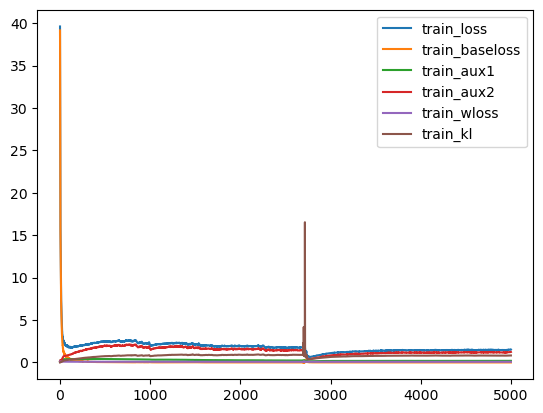

In [41]:
metrics = np.load('./sign/metrics/M_mse_512_256_128_5000_peryton_sign2_leakyReLU.npy', allow_pickle=True).item()
metrics.keys()
train_loss = metrics['train_loss']
train_baseloss = metrics['train_baseloss']
train_aux1 = metrics['train_aux1']
train_aux2 = metrics['train_aux2']
train_wloss = metrics['train_wloss']
train_kl = metrics['train_kl']
train_r2 = metrics['train_r2']
train_RMSE = metrics['train_RMSE']
plt.figure()
plt.plot(train_loss)
plt.plot(train_baseloss)
plt.plot(train_aux1)
plt.plot(train_aux2)
plt.plot(train_wloss)
plt.plot(train_kl)
plt.legend(['train_loss', 'train_baseloss', 'train_aux1', 'train_aux2', 'train_wloss', 'train_kl'])

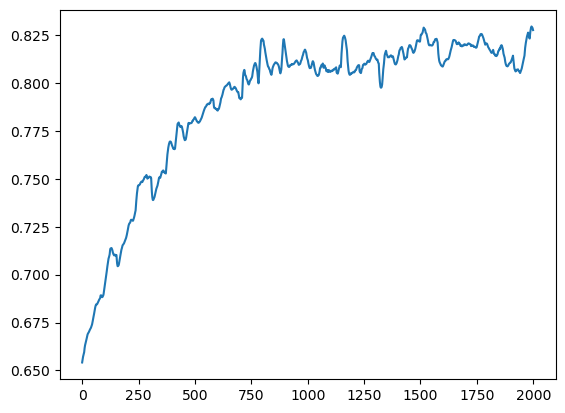

In [42]:
plt.plot(train_kl[3000:])

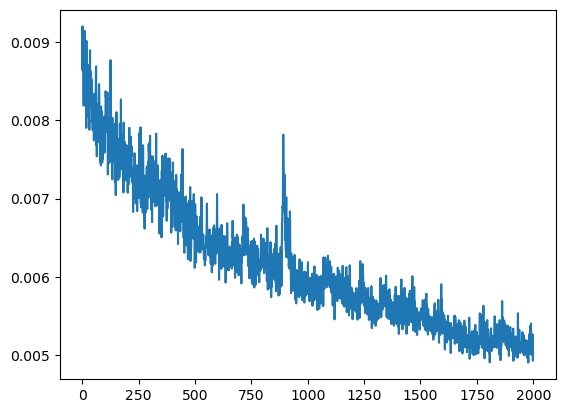

In [46]:
plt.plot(train_baseloss[3000:])

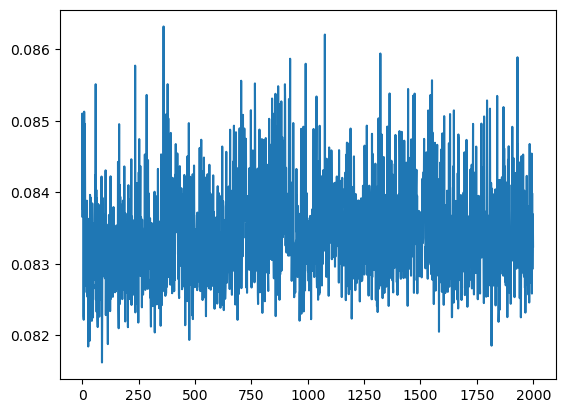

In [45]:
plt.plot(train_wloss[3000:])

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, precision_score, roc_auc_score
from sklearn import metrics
from xgboost.sklearn import XGBClassifier
import scipy.sparse as sp
from torch.optim import Adam

from layers import SinkhornDistance
from model_peryton import *
from utils import *
from get_sim import *
import args
import os
import time
import matplotlib.pyplot as plt
import random

/home/21031211508/anaconda3/envs/torch_zhu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/21031211508/anaconda3/envs/torch_zhu/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [7]:
torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# paprameters

random.seed(1)
k1 = 140  # mic
k2 = 5  # dis
A = pd.read_csv('./peryton/sign_final_ass.csv', index_col=0).to_numpy()

print("the number of microbes and diseases", A.shape)
print("the number of associations", sum(sum(A)))
x, y = A.shape
score_matrix = np.zeros([x, y])
samples = get_all_the_samples(A)

# sim_m, sim_d = get_sim_3ss_1ms_peryton(A, k1, k2)
sim_m, sim_d = np.load('./peryton/sim_m_sign.npy'), np.load('./peryton/sim_d_sign.npy')
sim_m_0 = set_digo_zero(sim_m, 0)
sim_d_0 = set_digo_zero(sim_d, 0)

the number of microbes and diseases (1396, 43)
the number of associations -88.0


In [8]:
sim_d_rand = np.random.randn(A.shape[1], A.shape[0])
# sim_d_rand = np.zeros_like(A.T)
sim_d = np.hstack((sim_d, sim_d_rand))
sim_m_rand = np.random.randn(A.shape[0], A.shape[1])
# sim_m_rand = np.zeros_like(A)
sim_m = np.hstack((sim_m, sim_m_rand))
features_m = np.vstack((sim_m, sim_d))
# features_m = sparse_to_tuple(sp.coo_matrix(features_m))

In [9]:
np.save('./peryton/features_random_for_pyg.npy', features_m)

In [5]:
np.eye(A.shape[0]) * 0.6

array([[0.6, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.6, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.6, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.6, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.6, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.6]])

In [25]:
alpha = 2
row = np.hstack((np.eye(A.shape[0]) * alpha, A))
row2 = np.hstack((A.T, np.eye(A.shape[1]) * alpha))
matrix = np.vstack((row, row2))
adj_norm = preprocess_graph_signGCN(matrix)
adj_norm

(array([[   0,    0],
        [1407,    0],
        [1419,    0],
        ...,
        [1387, 1438],
        [1388, 1438],
        [1438, 1438]], dtype=int32),
 array([ 0.5       ,  0.02063721,  0.07808688, ..., -0.28867513,
        -0.28867513,  0.33333333]),
 (1439, 1439))

In [26]:
ttt = adj_norm[1]

In [27]:
ttt.min()

-0.3535533905932738

In [32]:
a = np.linspace(0.1, 2, 20)
a

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [35]:
bbb = 1.0
str(bbb).replace('.', '_')

'1_0'